## Read time series data and split

In [3]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import discretize_func as discretize
import pickle

In [4]:
# Read
df = pd.read_parquet("dehli.parquet")

# Fill nans with nearest
df = df.ffill()

# Downsample from 5-min resolution to hourly
#df = df.resample("h").mean()

# Downsample from 5-min resolution to quarterly
df = df.resample("15min").mean()

# Change to numeric index (remove datetime)
df = df.reset_index(drop=True)

# Fill nans with nearest
df = df.ffill()

# Columns of interest
cols = ['Power demand', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres']
df = df[cols]

# Split in train/test
split_idx = int(len(df) * 0.8)
X = df.iloc[:split_idx].copy()
Y = df.iloc[split_idx:].copy()

## Pre-processing

* Normalize, (maybe derivate), discretize each column

In [5]:
# Z-norm standardisation
mu = X.mean()
sigma = X.std()

X_normalized = (X-mu)/sigma
X_nv = X_normalized.values.astype(np.float32)   # (N, D)

In [14]:
# fit bins
#edges, mids = discretize.fit_quantile_bins(X_nv, n_bins=10000)
edges, mids = discretize.fit_equal_width_bins(X_nv, n_bins=10000)

# encode
#X_tok = discretize.encode_quantile(jnp.asarray(X_nv), edges)
X_tok = discretize.encode_equal_width(jnp.asarray(X_nv), edges)

# decode
#X_rec = discretize.decode_quantile(X_tok, mids)
X_rec = discretize.decode_equal_width(X_tok, mids)


In [15]:
X

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
0,1999.076667,8.0,6.9,93.0,0.0,0.0,1017.0
1,1952.006667,8.0,6.9,93.0,0.0,0.0,1017.0
2,1882.133333,8.0,6.9,93.0,0.0,0.0,1017.0
3,1822.866667,8.0,6.9,93.0,0.0,0.0,1017.0
4,1779.133333,8.0,6.9,93.0,0.0,0.0,1017.0
...,...,...,...,...,...,...,...
110664,3506.576667,21.0,3.2,31.0,290.0,9.4,1017.0
110665,3504.670000,21.0,3.2,31.0,290.0,9.4,1017.0
110666,3478.290000,21.0,3.2,31.0,290.0,9.4,1017.0
110667,3443.300000,21.0,3.2,31.0,290.0,9.4,1017.0


In [16]:
X_reconstructed = (pd.DataFrame(X_rec, columns=X_normalized.columns) * sigma) + mu
X_reconstructed

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
0,1999.077208,8.0005,6.899705,93.003251,0.017992,0.00315,1016.998494
1,1951.804050,8.0005,6.899705,93.003251,0.017992,0.00315,1016.998494
2,1882.207383,8.0005,6.899705,93.003251,0.017992,0.00315,1016.998494
3,1823.115862,8.0005,6.899705,93.003251,0.017992,0.00315,1016.998494
4,1779.125525,8.0005,6.899705,93.003251,0.017992,0.00315,1016.998494
...,...,...,...,...,...,...,...
110664,3506.567163,20.9995,3.200315,30.996751,289.997994,9.40275,1016.998494
110665,3504.597411,20.9995,3.200315,30.996751,289.997994,9.40275,1016.998494
110666,3478.334546,20.9995,3.200315,30.996751,289.997994,9.40275,1016.998494
110667,3443.536212,20.9995,3.200315,30.996751,289.997994,9.40275,1016.998494


## Tokenize
* Tokenize each row: Channel+Value (on change), special time step token: 0

In [17]:
# Save token 0 as time step separator
X_tok = X_tok + 1

In [18]:
pd.DataFrame(X_tok)

,0,1,2,3,4,5,6
0,1038,953,3985,9264,1,1,7230
1,966,953,3985,9264,1,1,7230
2,860,953,3985,9264,1,1,7230
3,770,953,3985,9264,1,1,7230
4,703,953,3985,9264,1,1,7230
...,...,...,...,...,...,...,...
110664,3334,4048,3034,2737,8056,1493,7230
110665,3331,4048,3034,2737,8056,1493,7230
110666,3291,4048,3034,2737,8056,1493,7230
110667,3238,4048,3034,2737,8056,1493,7230


In [19]:
def flatten_rows_with_delimiter(x: jnp.ndarray, delimiter: int = 0):
    """
    x: (N, D) integer array
    returns: (N*(D+1),) 1D array
    """
    N, D = x.shape

    # append delimiter column
    delim_col = jnp.full((N, 1), delimiter, dtype=x.dtype)
    x_delim = jnp.concatenate([x, delim_col], axis=1)

    # flatten to 1D
    return x_delim.reshape(-1)

In [ ]:
tokens = flatten_rows_with_delimiter(X_tok)

# Training

In [25]:
import os
import requests
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
import optax
from jax import value_and_grad
import pickle
import pandas as pd
import math

from helper_funcs import generate, masked_fill, loss_fn, get_token_batch, encode, decode
from tqdm import tqdm
import matplotlib.pyplot as plt
print(jax.devices())

[CpuDevice(id=0)]


In [26]:
n_embed = 32 # Number of embedding dimensions
batch_size = 4 # How many independent sequences will we process in parallel?
block_size = 480 # What is the maximum context length for predictions?
num_heads = 4 # Number of heads in the multi-headed block
num_layers = 6 # Number of transformer decoder blocks
drop_rate = 0.1 # Dropout rate for regularization
token_id_col='token'

rng_key = jax.random.PRNGKey(128)

In [33]:
T = pd.DataFrame(tokens, columns=["token"])
vocab_size = T[token_id_col].max()
print(vocab_size)

10000


## Build the Attention Model

In [34]:
from attention_model import *
model = GPT2(vocab_size, n_embed, block_size, num_heads, num_layers, drop_rate)
dummy_x = jnp.zeros(shape=(batch_size, block_size), dtype=jnp.uint16)
variables = model.init(rng_key, dummy_x)

In [35]:
out = model.apply(variables, dummy_x)
print(out.shape)

(4, 480, 10000)


## Time Series Generation Pre-Training

In [36]:
index_seq = jnp.zeros(shape=(1,1), dtype=jnp.uint16)
max_new_tokens = 24
learning_rate=1e-4

#generated_indices = generate(variables, model.apply, index_seq, rng_key, vocab_size, 1, block_size, max_new_tokens)
#generated_indices = list(np.array(generated_indices[0]))
#decode(generated_indices, X)

## Train the Model

In [37]:
optimizer = optax.adamw(learning_rate=learning_rate)
opt_state = optimizer.init(variables)

In [40]:
epochs = 500
train_ids = T[token_id_col].to_numpy()
losses = []

pbar = tqdm(range(epochs))
for step in pbar:
    rng_key, subkey = jax.random.split(rng_key)
    xb, yb = get_token_batch(train_ids, subkey, batch_size, block_size)

    loss, grads = value_and_grad(loss_fn, argnums=(0))(
        variables, 
        model.apply,
        xb, 
        yb
    )
    updates, opt_state = optimizer.update(grads, opt_state, variables)
    variables = optax.apply_updates(variables, updates)

    if math.isnan(loss):
        break

    losses.append(loss)
    
    pbar.set_description(f"Epoch: {step}, Loss: {loss :.4f}")

  0%|          | 0/500 [00:03<?, ?it/s]


In [ ]:
# Save model
model_file = {
    "epochs": epochs,
    "epoch": step,
    "model": model,
    "vocab_size": vocab_size,
    "block_size": block_size,
    "variables": variables,
    "losses": losses,
    "opt_state": opt_state,
    "learning_rate": learning_rate,
}

with open('token_model.pickle', 'wb') as f:
    pickle.dump(model_file, f)

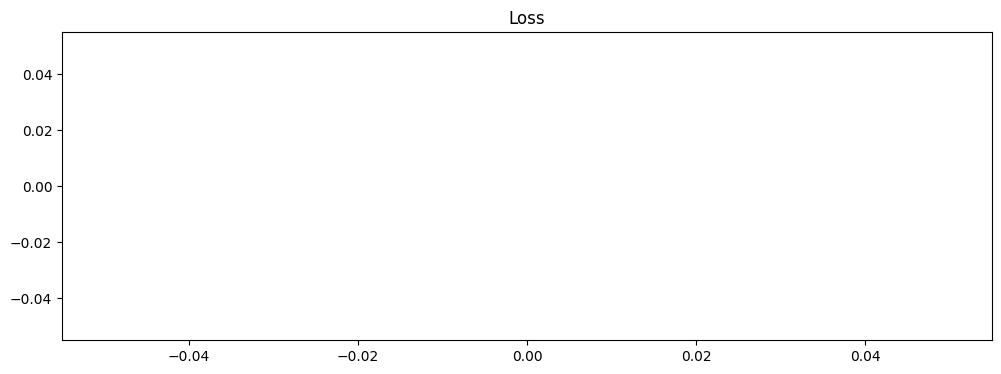

In [41]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.title('Loss')
plt.show()

## Time Series Generation Post-Training